In [66]:
import pandas as pd
from dtaidistance import dtw_ndim
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pyreadr

In [4]:
df = pd.read_csv('vitals_trajectory_imputed_no_unimputable.csv')

In [5]:
df

,EncID,event_hour,hospital_id,age_group,mods_day7,died_in_hosp,died_hour_round,FIO2Imputed,MAPImputed,PULSEImputed,PULSE_OXImputed,RESP_RATEImputed,SBPImputed,SF_RATIOImputed,TEMPImputed
0,10236 L2_P01,0,P01,1 mo,0,0,NaN,-0.728507,0.249764,0.772329,0.108161,0.573058,0.455669,0.588251,-0.132192
1,10236 L2_P01,1,P01,1 mo,0,0,NaN,-0.728507,0.064598,1.069369,0.108161,0.094031,0.107226,0.588251,0.408066
2,10236 L2_P01,2,P01,1 mo,0,0,NaN,-0.621291,0.591607,0.973106,0.495734,-0.155462,0.293062,0.435020,0.678195
3,10236 L2_P01,3,P01,1 mo,0,0,NaN,-0.514075,0.021868,1.193135,0.108161,-0.280208,0.176915,0.188200,0.948324
4,10236 L2_P01,4,P01,1 mo,0,0,NaN,-0.406859,0.192790,0.986858,0.274264,-0.280208,-0.101839,0.051275,0.828268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166707,986_P13,8,P13,60 to 143 mo,0,0,NaN,0.247069,1.795330,-0.970044,0.741121,-1.287351,1.546742,-0.639474,-0.302156
166708,986_P13,9,P13,60 to 143 mo,0,0,NaN,0.247069,2.537591,-1.456137,0.232641,-0.750075,2.380789,-0.670668,-0.324022
166709,986_P13,10,P13,60 to 143 mo,0,0,NaN,0.247069,2.205526,-1.140177,0.614001,-0.321706,1.948002,-0.647272,-0.345888
166710,986_P13,11,P13,60 to 143 mo,0,0,NaN,0.247069,1.761147,-1.121273,-0.021599,-0.677470,1.637026,-0.686265,-0.345888


In [6]:
# record row index and event hour of died patient, which should be removed from traj_arr
death_info=df[df['event_hour']>df['died_hour_round']][['EncID','event_hour']]
death_encid_index = [df['EncID'].unique().tolist().index(i) for i in death_info['EncID'].tolist()]
death_info['encid_index'] = death_encid_index
to_remove = death_info.sort_values(['encid_index','event_hour']).groupby('encid_index').first()

In [7]:
to_remove

,EncID,event_hour
encid_index,,
52,14041 L2_P01,8
338,17732 L2_P01,3
417,9858 L2_P01,9
446,13305 L2_P01,5
466,15037 L2_P01,8
...,...,...
12333,953_P13,5
12336,961_P13,12
12478,2134_P13,11


In [8]:
# [[feature1_time1, feature2_time1, feature3_time1], [feature1_time2, feature2_time2, feature3_time2], ...]
traj_arr = np.reshape(np.array(df[["MAPImputed","PULSEImputed","RESP_RATEImputed",
                                   "SBPImputed","SF_RATIOImputed","TEMPImputed"]]), 
                      (df['EncID'].nunique(),df['event_hour'].nunique(),6))
traj_arr.shape

(12824, 13, 6)

In [9]:
traj_list = traj_arr.copy().tolist()
for idx,hr in zip(to_remove.index.tolist(),to_remove['event_hour'].tolist()):
    traj_i_updated = np.delete(traj_list[idx],np.s_[hr:13], axis = 0)
    traj_list[idx] = traj_i_updated.tolist()
    print(to_remove.loc[idx]['EncID'],len(traj_list[idx]))

14041 L2_P01 8
17732 L2_P01 3
9858 L2_P01 9
13305 L2_P01 5
15037 L2_P01 8
10904 L2_P01 9
12502 L2_P01 8
17099_P02 10
29863_P02 11
38422_P02 8
34136_P02 7
34393_P02 11
6627_P02 10
13365_P03 6
13237_P03 12
290_P03 9
3883_P03 4
588_P03 10
330_P03 8
12252_P03 12
1999_P03 10
10102_P03 8
1499_P03 9
15607_P03 6
3296_P03 10
10006704_P04 7
10006769_P04 6
10006441_P04 4
10006488_P04 8
10004645_P04 11
10006980_P04 11
10007105_P04 8
10007534_P04 1
1466305662_P05 9
1854623989_P05 6
438885667_P05 12
2078399242_P05 10
893886663_P05 6
1859148828_P05 8
2027326714_P05 6
2058779171_P05 3
45669297_P05 10
600460944_P05 10
7453954_P05 12
1840599116_P05 4
1833577666_P05 6
76725403_P05 3
933033062_P05 11
1286883976_P06 12
1587079846_P06 3
1113937696_P06 5
1162818970_P06 12
816965683_P06 11
20201645_P07 10
11801133_P07 9
11_P08 6
46268702_P09 11
46230815_P09 7
48845675_P11 5
83474336_P11 3
237400566_P11 8
264452117_P11 11
73385961_P11 12
178736265_P11 5
101366_P12 9
102015_P12 10
101437_P12 7
100765_P12 10
100

In [152]:
# before removing na
dtw_ndim.distance(traj_arr[0], traj_arr[52], penalty = 5)

nan

In [183]:
# after removing na
dtw_ndim.distance(np.array(traj_list[0]), np.array(traj_list[52]), penalty = 5)

16.59941382184558

In [ ]:
# mt = dtw_ndim.distance_matrix(traj_arr, penalty = 1)
mt = np.zeros((traj_arr.shape[0],traj_arr.shape[0]))
start_time = time.time()
# function for dtw matrix
for i in range(traj_arr.shape[0]):
    j = i + 1
    #with open ('dtw_prog.txt', 'a') as f:
        #f.write(str(i))
        #f.write('\n')
    #f.close()
    print(round(time.time()-start_time,2), 'init: ', i,j)
    while j < traj_arr.shape[0]:
        dtw = dtw_ndim.distance(np.array(traj_list[i]), np.array(traj_list[j]), penalty = 5)
        mt[i,j] = dtw
        mt[j,i] = dtw
        j+= 1
        #print('loop', i,j)

0.0 init:  0 1
20.36 init:  1 2
41.17 init:  2 3
61.55 init:  3 4
81.93 init:  4 5
101.93 init:  5 6
122.09 init:  6 7
141.82 init:  7 8
161.77 init:  8 9
182.08 init:  9 10
201.85 init:  10 11
221.79 init:  11 12
242.9 init:  12 13
262.82 init:  13 14
282.94 init:  14 15
303.66 init:  15 16
323.54 init:  16 17
344.37 init:  17 18
364.86 init:  18 19
385.45 init:  19 20
406.44 init:  20 21
426.64 init:  21 22
446.87 init:  22 23
467.94 init:  23 24
488.83 init:  24 25
509.81 init:  25 26
530.38 init:  26 27
550.4 init:  27 28
571.21 init:  28 29
592.39 init:  29 30
613.3 init:  30 31
634.31 init:  31 32
654.43 init:  32 33
674.82 init:  33 34
695.15 init:  34 35
715.44 init:  35 36
736.54 init:  36 37
756.62 init:  37 38
777.12 init:  38 39
797.38 init:  39 40
817.55 init:  40 41
837.43 init:  41 42
857.47 init:  42 43
877.56 init:  43 44
897.64 init:  44 45
917.86 init:  45 46
938.19 init:  46 47
958.66 init:  47 48
979.2 init:  48 49
1000.24 init:  49 50
1021.37 init:  50 51
1041.5 i

7765.09 init:  370 371
7785.29 init:  371 372
7805.63 init:  372 373
7825.94 init:  373 374
7846.02 init:  374 375
7866.4 init:  375 376
7886.67 init:  376 377
7907.14 init:  377 378
7927.27 init:  378 379
7947.63 init:  379 380
7967.7 init:  380 381
7987.85 init:  381 382
8007.91 init:  382 383
8028.22 init:  383 384
8048.28 init:  384 385
8068.58 init:  385 386
8089.18 init:  386 387
8109.63 init:  387 388
8129.77 init:  388 389
8149.85 init:  389 390
8170.36 init:  390 391
8191.26 init:  391 392
8211.56 init:  392 393
8231.49 init:  393 394
8251.82 init:  394 395
8272.16 init:  395 396
8293.0 init:  396 397
8313.36 init:  397 398
8333.85 init:  398 399
8356.09 init:  399 400
8376.31 init:  400 401
8396.47 init:  401 402
8416.79 init:  402 403
8437.5 init:  403 404
8457.57 init:  404 405
8477.73 init:  405 406
8498.11 init:  406 407
8518.48 init:  407 408
8538.26 init:  408 409
8558.51 init:  409 410
8578.55 init:  410 411
8598.85 init:  411 412
8619.3 init:  412 413
8639.09 init:  4

14687.16 init:  718 719
14706.52 init:  719 720
14725.67 init:  720 721
14745.28 init:  721 722
14764.28 init:  722 723
14783.62 init:  723 724
14802.67 init:  724 725
14822.46 init:  725 726
14841.65 init:  726 727
14860.97 init:  727 728
14879.87 init:  728 729
14899.49 init:  729 730
14918.57 init:  730 731
14937.82 init:  731 732
14957.14 init:  732 733
14976.6 init:  733 734
14995.84 init:  734 735
15015.17 init:  735 736
15034.42 init:  736 737
15055.13 init:  737 738
15074.23 init:  738 739
15093.52 init:  739 740
15112.43 init:  740 741
15131.39 init:  741 742
15150.26 init:  742 743
15169.41 init:  743 744
15188.79 init:  744 745
15208.49 init:  745 746
15227.26 init:  746 747
15239.17 init:  747 748
15258.28 init:  748 749
15277.71 init:  749 750
15296.69 init:  750 751
15315.85 init:  751 752
15335.13 init:  752 753
15354.33 init:  753 754
15373.48 init:  754 755
15392.78 init:  755 756
15411.87 init:  756 757
15431.05 init:  757 758
15450.27 init:  758 759
15469.78 init:  7

24481.89 init:  1228 1229
24503.96 init:  1229 1230
24525.83 init:  1230 1231
24547.44 init:  1231 1232
24569.46 init:  1232 1233
24589.46 init:  1233 1234
24608.44 init:  1234 1235
24627.37 init:  1235 1236
24646.3 init:  1236 1237
24665.48 init:  1237 1238
24684.5 init:  1238 1239
24703.57 init:  1239 1240
24722.44 init:  1240 1241
24742.56 init:  1241 1242
24764.82 init:  1242 1243
24787.82 init:  1243 1244
24809.86 init:  1244 1245
24832.46 init:  1245 1246
24855.05 init:  1246 1247
24877.64 init:  1247 1248
24899.47 init:  1248 1249
24918.5 init:  1249 1250
24937.4 init:  1250 1251
24956.58 init:  1251 1252
24977.97 init:  1252 1253
25000.84 init:  1253 1254
25020.75 init:  1254 1255
25039.55 init:  1255 1256
25058.31 init:  1256 1257
25076.87 init:  1257 1258
25095.48 init:  1258 1259
25114.05 init:  1259 1260
25132.58 init:  1260 1261
25151.04 init:  1261 1262
25169.24 init:  1262 1263
25187.5 init:  1263 1264
25205.99 init:  1264 1265
25224.75 init:  1265 1266
25243.36 init:  1

30402.05 init:  1545 1546
30420.16 init:  1546 1547
30438.18 init:  1547 1548
30455.99 init:  1548 1549
30473.93 init:  1549 1550
30491.83 init:  1550 1551
30509.56 init:  1551 1552
30527.63 init:  1552 1553
30545.44 init:  1553 1554
30563.2 init:  1554 1555
30580.99 init:  1555 1556
30598.82 init:  1556 1557
30616.69 init:  1557 1558
30634.56 init:  1558 1559
30652.62 init:  1559 1560
30672.47 init:  1560 1561
30690.27 init:  1561 1562
30708.38 init:  1562 1563
30727.19 init:  1563 1564
30745.08 init:  1564 1565
30762.83 init:  1565 1566
30780.64 init:  1566 1567
30798.84 init:  1567 1568
30816.97 init:  1568 1569
30835.2 init:  1569 1570
30854.15 init:  1570 1571
30872.34 init:  1571 1572
30890.41 init:  1572 1573
30909.21 init:  1573 1574
30927.33 init:  1574 1575
30945.51 init:  1575 1576
30963.55 init:  1576 1577
30981.55 init:  1577 1578
30999.67 init:  1578 1579
31017.54 init:  1579 1580
31035.53 init:  1580 1581
31053.57 init:  1581 1582
31071.95 init:  1582 1583
31090.22 init:

36054.76 init:  1862 1863
36072.18 init:  1863 1864
36089.37 init:  1864 1865
36106.55 init:  1865 1866
36123.91 init:  1866 1867
36142.37 init:  1867 1868
36159.66 init:  1868 1869
36177.01 init:  1869 1870
36194.37 init:  1870 1871
36211.85 init:  1871 1872
36229.41 init:  1872 1873
36246.67 init:  1873 1874
36264.31 init:  1874 1875
36281.67 init:  1875 1876
36299.28 init:  1876 1877
36316.44 init:  1877 1878
36333.62 init:  1878 1879
36350.66 init:  1879 1880
36367.65 init:  1880 1881
36384.61 init:  1881 1882
36401.84 init:  1882 1883
36419.29 init:  1883 1884
36437.4 init:  1884 1885
36455.02 init:  1885 1886
36473.61 init:  1886 1887
36491.14 init:  1887 1888
36508.59 init:  1888 1889
36525.91 init:  1889 1890
36543.56 init:  1890 1891
36561.02 init:  1891 1892
36578.13 init:  1892 1893
36595.61 init:  1893 1894
36613.52 init:  1894 1895
36631.2 init:  1895 1896
36648.56 init:  1896 1897
36666.29 init:  1897 1898
36683.77 init:  1898 1899
36701.25 init:  1899 1900
36718.64 init:

41505.68 init:  2179 2180
41523.4 init:  2180 2181
41540.1 init:  2181 2182
41556.85 init:  2182 2183
41574.81 init:  2183 2184
41591.83 init:  2184 2185
41608.98 init:  2185 2186
41626.5 init:  2186 2187
41643.42 init:  2187 2188
41660.13 init:  2188 2189
41676.99 init:  2189 2190
41693.84 init:  2190 2191
41710.94 init:  2191 2192
41727.78 init:  2192 2193
41744.2 init:  2193 2194
41760.96 init:  2194 2195
41777.89 init:  2195 2196
41794.79 init:  2196 2197
41811.52 init:  2197 2198
41829.21 init:  2198 2199
41846.93 init:  2199 2200
41863.85 init:  2200 2201
41880.62 init:  2201 2202
41897.39 init:  2202 2203
41914.23 init:  2203 2204
41930.83 init:  2204 2205
41947.46 init:  2205 2206
41964.34 init:  2206 2207
41980.87 init:  2207 2208
41997.61 init:  2208 2209
42014.06 init:  2209 2210
42030.74 init:  2210 2211
42047.32 init:  2211 2212
42064.0 init:  2212 2213
42080.76 init:  2213 2214
42097.47 init:  2214 2215
42114.43 init:  2215 2216
42131.23 init:  2216 2217
42148.15 init:  2

46861.63 init:  2496 2497
46877.75 init:  2497 2498
46893.93 init:  2498 2499
46910.07 init:  2499 2500
46926.36 init:  2500 2501
46942.65 init:  2501 2502
46958.87 init:  2502 2503
46975.06 init:  2503 2504
46991.68 init:  2504 2505
47007.99 init:  2505 2506
47024.14 init:  2506 2507
47041.58 init:  2507 2508
47060.99 init:  2508 2509
47076.91 init:  2509 2510
47092.92 init:  2510 2511
47109.1 init:  2511 2512
47125.26 init:  2512 2513
47141.52 init:  2513 2514
47157.74 init:  2514 2515
47174.01 init:  2515 2516
47190.08 init:  2516 2517
47206.43 init:  2517 2518
47222.75 init:  2518 2519
47238.78 init:  2519 2520
47254.81 init:  2520 2521
47270.93 init:  2521 2522
47286.99 init:  2522 2523
47303.23 init:  2523 2524
47319.31 init:  2524 2525
47335.21 init:  2525 2526
47351.5 init:  2526 2527
47367.71 init:  2527 2528
47383.89 init:  2528 2529
47400.12 init:  2529 2530
47416.32 init:  2530 2531
47432.96 init:  2531 2532
47449.25 init:  2532 2533
47465.78 init:  2533 2534
47481.98 init:

55704.96 init:  3039 3040
55720.55 init:  3040 3041
55736.69 init:  3041 3042
55752.3 init:  3042 3043
55767.94 init:  3043 3044
55783.4 init:  3044 3045
55799.7 init:  3045 3046
55816.6 init:  3046 3047
55833.28 init:  3047 3048
55850.18 init:  3048 3049
55866.59 init:  3049 3050
55882.5 init:  3050 3051
55898.59 init:  3051 3052
55914.49 init:  3052 3053
55929.97 init:  3053 3054
55945.98 init:  3054 3055
55962.16 init:  3055 3056
55977.23 init:  3056 3057
55992.59 init:  3057 3058
56007.82 init:  3058 3059
56023.26 init:  3059 3060
56038.52 init:  3060 3061
56053.65 init:  3061 3062
56069.01 init:  3062 3063
56085.13 init:  3063 3064
56101.0 init:  3064 3065
56116.71 init:  3065 3066
56131.99 init:  3066 3067
56147.44 init:  3067 3068
56162.98 init:  3068 3069
56178.98 init:  3069 3070
56196.05 init:  3070 3071
56211.88 init:  3071 3072
56228.09 init:  3072 3073
56244.77 init:  3073 3074
56260.04 init:  3074 3075
56275.37 init:  3075 3076
56290.57 init:  3076 3077
56306.72 init:  30

62609.0 init:  3474 3475
62624.98 init:  3475 3476
62640.49 init:  3476 3477
62655.99 init:  3477 3478
62672.47 init:  3478 3479
62687.49 init:  3479 3480
62703.87 init:  3480 3481
62720.73 init:  3481 3482
62736.71 init:  3482 3483
62753.3 init:  3483 3484
62770.78 init:  3484 3485
62786.13 init:  3485 3486
62801.0 init:  3486 3487
62816.24 init:  3487 3488
62830.71 init:  3488 3489
62845.51 init:  3489 3490
62861.19 init:  3490 3491
62878.09 init:  3491 3492
62894.62 init:  3492 3493
62909.82 init:  3493 3494
62925.85 init:  3494 3495
62942.68 init:  3495 3496
62960.04 init:  3496 3497
62976.99 init:  3497 3498
62994.24 init:  3498 3499
63010.24 init:  3499 3500
63025.06 init:  3500 3501
63039.9 init:  3501 3502
63056.07 init:  3502 3503
63072.79 init:  3503 3504
63087.67 init:  3504 3505
63102.99 init:  3505 3506
63117.69 init:  3506 3507
63133.55 init:  3507 3508
63148.92 init:  3508 3509
63163.43 init:  3509 3510
63179.22 init:  3510 3511
63195.04 init:  3511 3512
63210.21 init:  

67499.64 init:  3790 3791
67514.04 init:  3791 3792
67528.77 init:  3792 3793
67543.55 init:  3793 3794
67558.76 init:  3794 3795
67573.67 init:  3795 3796
67587.89 init:  3796 3797
67602.97 init:  3797 3798
67619.21 init:  3798 3799
67633.67 init:  3799 3800
67648.35 init:  3800 3801
67662.96 init:  3801 3802
67678.29 init:  3802 3803
67695.17 init:  3803 3804
67710.92 init:  3804 3805
67726.02 init:  3805 3806
67741.62 init:  3806 3807
67756.38 init:  3807 3808
67771.39 init:  3808 3809
67788.44 init:  3809 3810
67803.88 init:  3810 3811
67818.42 init:  3811 3812
67834.24 init:  3812 3813
67849.07 init:  3813 3814
67862.08 init:  3814 3815
67876.39 init:  3815 3816
67891.0 init:  3816 3817
67905.63 init:  3817 3818
67920.99 init:  3818 3819
67937.24 init:  3819 3820
67951.96 init:  3820 3821
67966.65 init:  3821 3822
67983.3 init:  3822 3823
67998.09 init:  3823 3824
68014.87 init:  3824 3825
68030.45 init:  3825 3826
68045.0 init:  3826 3827
68059.39 init:  3827 3828
68076.06 init: 

72266.39 init:  4107 4108
72280.26 init:  4108 4109
72295.28 init:  4109 4110
72310.87 init:  4110 4111
72325.95 init:  4111 4112
72342.06 init:  4112 4113
72356.04 init:  4113 4114
72371.83 init:  4114 4115
72385.83 init:  4115 4116
72401.32 init:  4116 4117
72415.3 init:  4117 4118
72430.23 init:  4118 4119
72444.14 init:  4119 4120
72458.25 init:  4120 4121
72473.14 init:  4121 4122
72488.4 init:  4122 4123
72502.46 init:  4123 4124
72516.38 init:  4124 4125
72530.69 init:  4125 4126
72531.9 init:  4126 4127
72546.71 init:  4127 4128
72561.7 init:  4128 4129
72575.63 init:  4129 4130
72590.07 init:  4130 4131
72605.13 init:  4131 4132
72619.54 init:  4132 4133
72634.07 init:  4133 4134
72649.6 init:  4134 4135
72664.23 init:  4135 4136
72678.91 init:  4136 4137
72693.43 init:  4137 4138
72707.47 init:  4138 4139
72722.16 init:  4139 4140
72736.13 init:  4140 4141
72751.27 init:  4141 4142
72766.07 init:  4142 4143
72780.12 init:  4143 4144
72794.05 init:  4144 4145
72808.9 init:  41

76806.57 init:  4424 4425
76821.42 init:  4425 4426
76834.22 init:  4426 4427
76849.06 init:  4427 4428
76863.23 init:  4428 4429
76877.27 init:  4429 4430
76890.75 init:  4430 4431
76904.57 init:  4431 4432
76920.24 init:  4432 4433
76934.85 init:  4433 4434
76948.47 init:  4434 4435
76963.23 init:  4435 4436
76976.57 init:  4436 4437
76990.22 init:  4437 4438
77003.63 init:  4438 4439
77017.35 init:  4439 4440
77031.11 init:  4440 4441
77044.74 init:  4441 4442
77058.95 init:  4442 4443
77073.59 init:  4443 4444
77087.44 init:  4444 4445
77102.47 init:  4445 4446
77117.29 init:  4446 4447
77130.93 init:  4447 4448
77145.0 init:  4448 4449
77158.75 init:  4449 4450
77173.13 init:  4450 4451
77186.9 init:  4451 4452
77201.67 init:  4452 4453
77215.74 init:  4453 4454
77230.02 init:  4454 4455
77243.58 init:  4455 4456
77256.95 init:  4456 4457
77270.25 init:  4457 4458
77284.36 init:  4458 4459
77298.94 init:  4459 4460
77313.98 init:  4460 4461
77327.54 init:  4461 4462
77343.17 init:

81383.77 init:  4755 4756
81397.24 init:  4756 4757
81411.8 init:  4757 4758
81424.92 init:  4758 4759
81438.12 init:  4759 4760
81451.05 init:  4760 4761
81464.28 init:  4761 4762
81477.75 init:  4762 4763
81491.41 init:  4763 4764
81504.94 init:  4764 4765
81517.91 init:  4765 4766
81530.81 init:  4766 4767
81545.16 init:  4767 4768
81558.83 init:  4768 4769
81572.25 init:  4769 4770
81585.61 init:  4770 4771
81598.42 init:  4771 4772
81611.6 init:  4772 4773
81624.86 init:  4773 4774
81637.62 init:  4774 4775
81650.34 init:  4775 4776
81664.33 init:  4776 4777
81678.3 init:  4777 4778
81691.21 init:  4778 4779
81704.03 init:  4779 4780
81716.88 init:  4780 4781
81730.2 init:  4781 4782
81743.08 init:  4782 4783
81755.82 init:  4783 4784
81768.68 init:  4784 4785
81783.8 init:  4785 4786
81797.01 init:  4786 4787
81809.98 init:  4787 4788
81822.9 init:  4788 4789
81836.15 init:  4789 4790
81849.83 init:  4790 4791
81862.58 init:  4791 4792
81876.81 init:  4792 4793
81890.2 init:  479

85543.39 init:  5072 5073
85555.99 init:  5073 5074
85569.22 init:  5074 5075
85583.67 init:  5075 5076
85595.95 init:  5076 5077
85608.87 init:  5077 5078
85621.58 init:  5078 5079
85636.0 init:  5079 5080
85648.13 init:  5080 5081
85660.84 init:  5081 5082
85674.33 init:  5082 5083
85685.82 init:  5083 5084
85698.41 init:  5084 5085
85711.33 init:  5085 5086
85723.81 init:  5086 5087
85736.58 init:  5087 5088
85749.22 init:  5088 5089
85761.99 init:  5089 5090
85774.72 init:  5090 5091
85787.49 init:  5091 5092
85799.94 init:  5092 5093
85812.79 init:  5093 5094
85826.13 init:  5094 5095
85838.83 init:  5095 5096
85851.3 init:  5096 5097
85865.68 init:  5097 5098
85878.33 init:  5098 5099
85890.52 init:  5099 5100
85902.8 init:  5100 5101
85915.69 init:  5101 5102
85928.38 init:  5102 5103
85941.99 init:  5103 5104
85954.88 init:  5104 5105
85967.58 init:  5105 5106
85980.22 init:  5106 5107
85992.98 init:  5107 5108
86005.43 init:  5108 5109
86017.89 init:  5109 5110
86030.22 init: 

89566.57 init:  5389 5390
89578.86 init:  5390 5391
89591.14 init:  5391 5392
89603.42 init:  5392 5393
89615.73 init:  5393 5394
89628.0 init:  5394 5395
89640.41 init:  5395 5396
89652.58 init:  5396 5397
89664.87 init:  5397 5398
89676.99 init:  5398 5399
89689.2 init:  5399 5400
89701.35 init:  5400 5401
89713.67 init:  5401 5402
89725.98 init:  5402 5403
89738.38 init:  5403 5404
89750.66 init:  5404 5405
89766.61 init:  5405 5406
89780.76 init:  5406 5407
89793.56 init:  5407 5408
89806.86 init:  5408 5409
89819.1 init:  5409 5410
89831.33 init:  5410 5411
89843.65 init:  5411 5412
89856.02 init:  5412 5413
89868.24 init:  5413 5414
89880.35 init:  5414 5415
89892.67 init:  5415 5416
89904.86 init:  5416 5417
89917.08 init:  5417 5418
89929.74 init:  5418 5419
89942.15 init:  5419 5420
89954.37 init:  5420 5421
89966.66 init:  5421 5422
89978.82 init:  5422 5423
89990.96 init:  5423 5424
90003.04 init:  5424 5425
90015.23 init:  5425 5426
90027.36 init:  5426 5427
90039.51 init: 

93365.85 init:  5706 5707
93377.62 init:  5707 5708
93389.43 init:  5708 5709
93401.24 init:  5709 5710
93412.92 init:  5710 5711
93424.78 init:  5711 5712
93436.5 init:  5712 5713
93448.27 init:  5713 5714
93460.01 init:  5714 5715
93471.76 init:  5715 5716
93483.52 init:  5716 5717
93495.31 init:  5717 5718
93506.92 init:  5718 5719
93518.69 init:  5719 5720
93530.43 init:  5720 5721
93542.2 init:  5721 5722
93553.97 init:  5722 5723
93565.66 init:  5723 5724
93577.4 init:  5724 5725
93589.16 init:  5725 5726
93600.94 init:  5726 5727
93613.0 init:  5727 5728
93624.98 init:  5728 5729
93637.08 init:  5729 5730
93649.1 init:  5730 5731
93661.02 init:  5731 5732
93673.04 init:  5732 5733
93684.96 init:  5733 5734
93696.64 init:  5734 5735
93708.29 init:  5735 5736
93720.07 init:  5736 5737
93731.85 init:  5737 5738
93743.55 init:  5738 5739
93755.32 init:  5739 5740
93767.11 init:  5740 5741
93778.97 init:  5741 5742
93790.93 init:  5742 5743
93802.75 init:  5743 5744
93814.59 init:  5

96997.24 init:  6023 6024
97008.46 init:  6024 6025
97019.68 init:  6025 6026
97030.86 init:  6026 6027
97042.12 init:  6027 6028
97053.3 init:  6028 6029
97064.52 init:  6029 6030
97075.66 init:  6030 6031
97086.96 init:  6031 6032
97098.11 init:  6032 6033
97109.34 init:  6033 6034
97120.48 init:  6034 6035
97131.81 init:  6035 6036
97143.02 init:  6036 6037
97154.25 init:  6037 6038
97165.46 init:  6038 6039
97176.7 init:  6039 6040
97187.89 init:  6040 6041
97199.1 init:  6041 6042
97210.21 init:  6042 6043
97221.49 init:  6043 6044
97232.57 init:  6044 6045
97243.69 init:  6045 6046
97254.83 init:  6046 6047
97266.01 init:  6047 6048
97277.17 init:  6048 6049
97288.43 init:  6049 6050
97299.64 init:  6050 6051
97304.07 init:  6051 6052
97315.24 init:  6052 6053
97326.53 init:  6053 6054
97337.98 init:  6054 6055
97349.29 init:  6055 6056
97359.8 init:  6056 6057
97371.29 init:  6057 6058
97382.68 init:  6058 6059
97394.13 init:  6059 6060
97405.56 init:  6060 6061
97416.95 init:  

100448.15 init:  6338 6339
100458.94 init:  6339 6340
100469.61 init:  6340 6341
100480.36 init:  6341 6342
100491.1 init:  6342 6343
100501.84 init:  6343 6344
100512.49 init:  6344 6345
100523.23 init:  6345 6346
100533.93 init:  6346 6347
100544.65 init:  6347 6348
100555.37 init:  6348 6349
100566.08 init:  6349 6350
100576.79 init:  6350 6351
100587.5 init:  6351 6352
100598.17 init:  6352 6353
100608.87 init:  6353 6354
100619.51 init:  6354 6355
100630.21 init:  6355 6356
100640.87 init:  6356 6357
100651.62 init:  6357 6358
100662.28 init:  6358 6359
100672.89 init:  6359 6360
100683.59 init:  6360 6361
100694.39 init:  6361 6362
100705.09 init:  6362 6363
100715.8 init:  6363 6364
100726.47 init:  6364 6365
100737.18 init:  6365 6366
100747.79 init:  6366 6367
100758.29 init:  6367 6368
100768.72 init:  6368 6369
100779.45 init:  6369 6370
100790.15 init:  6370 6371
100800.87 init:  6371 6372
100811.5 init:  6372 6373
100822.11 init:  6373 6374
100832.77 init:  6374 6375
10084

103637.72 init:  6643 6644
103648.21 init:  6644 6645
103658.74 init:  6645 6646
103669.24 init:  6646 6647
103679.75 init:  6647 6648
103690.19 init:  6648 6649
103700.59 init:  6649 6650
103710.97 init:  6650 6651
103721.33 init:  6651 6652
103731.66 init:  6652 6653
103742.08 init:  6653 6654
103752.42 init:  6654 6655
103762.79 init:  6655 6656
103770.81 init:  6656 6657
103781.2 init:  6657 6658
103791.47 init:  6658 6659
103801.82 init:  6659 6660
103812.13 init:  6660 6661
103822.57 init:  6661 6662
103832.94 init:  6662 6663
103843.34 init:  6663 6664
103853.68 init:  6664 6665
103864.13 init:  6665 6666
103874.6 init:  6666 6667
103884.98 init:  6667 6668
103895.33 init:  6668 6669
103905.51 init:  6669 6670
103915.63 init:  6670 6671
103925.81 init:  6671 6672
103936.02 init:  6672 6673
103946.17 init:  6673 6674
103956.31 init:  6674 6675
103966.47 init:  6675 6676
103976.59 init:  6676 6677
103986.79 init:  6677 6678
103996.95 init:  6678 6679
104007.09 init:  6679 6680
104

106660.51 init:  6948 6949
106670.26 init:  6949 6950
106679.89 init:  6950 6951
106689.59 init:  6951 6952
106699.3 init:  6952 6953
106708.94 init:  6953 6954
106718.54 init:  6954 6955
106728.32 init:  6955 6956
106737.94 init:  6956 6957
106747.67 init:  6957 6958
106757.32 init:  6958 6959
106767.07 init:  6959 6960
106776.76 init:  6960 6961
106786.55 init:  6961 6962
106796.28 init:  6962 6963
106806.01 init:  6963 6964
106815.74 init:  6964 6965
106825.54 init:  6965 6966
106835.23 init:  6966 6967
106844.8 init:  6967 6968
106854.24 init:  6968 6969
106863.83 init:  6969 6970
106873.53 init:  6970 6971
106883.13 init:  6971 6972
106892.76 init:  6972 6973
106902.56 init:  6973 6974
106912.31 init:  6974 6975
106922.01 init:  6975 6976
106931.72 init:  6976 6977
106941.46 init:  6977 6978
106951.08 init:  6978 6979
106960.81 init:  6979 6980
106970.45 init:  6980 6981
106980.26 init:  6981 6982
106989.69 init:  6982 6983
106999.22 init:  6983 6984
107008.74 init:  6984 6985
107

109544.92 init:  7253 7254
109554.16 init:  7254 7255
109563.39 init:  7255 7256
109572.58 init:  7256 7257
109581.84 init:  7257 7258
109591.06 init:  7258 7259
109600.23 init:  7259 7260
109609.42 init:  7260 7261
109618.62 init:  7261 7262
109627.78 init:  7262 7263
109637.02 init:  7263 7264
109646.2 init:  7264 7265
109655.32 init:  7265 7266
109664.41 init:  7266 7267
109673.62 init:  7267 7268
109682.81 init:  7268 7269
109691.97 init:  7269 7270
109701.14 init:  7270 7271
109710.31 init:  7271 7272
109719.47 init:  7272 7273
109728.72 init:  7273 7274
109737.84 init:  7274 7275
109747.09 init:  7275 7276
109756.16 init:  7276 7277
109765.28 init:  7277 7278
109774.46 init:  7278 7279
109783.62 init:  7279 7280
109792.81 init:  7280 7281
109802.05 init:  7281 7282
109811.19 init:  7282 7283
109820.34 init:  7283 7284
109829.75 init:  7284 7285
109839.16 init:  7285 7286
109848.57 init:  7286 7287
109857.99 init:  7287 7288
109867.35 init:  7288 7289
109876.74 init:  7289 7290
10

112225.28 init:  7558 7559
112233.69 init:  7559 7560
112242.0 init:  7560 7561
112250.35 init:  7561 7562
112258.7 init:  7562 7563
112267.14 init:  7563 7564
112275.51 init:  7564 7565
112284.2 init:  7565 7566
112292.8 init:  7566 7567
112301.34 init:  7567 7568
112309.8 init:  7568 7569
112318.11 init:  7569 7570
112326.45 init:  7570 7571
112334.79 init:  7571 7572
112343.17 init:  7572 7573
112351.62 init:  7573 7574
112360.13 init:  7574 7575
112368.7 init:  7575 7576
112377.08 init:  7576 7577
112385.59 init:  7577 7578
112394.13 init:  7578 7579
112402.6 init:  7579 7580
112411.16 init:  7580 7581
112419.78 init:  7581 7582
112428.37 init:  7582 7583
112436.9 init:  7583 7584
112445.56 init:  7584 7585
112454.13 init:  7585 7586
112462.63 init:  7586 7587
112471.2 init:  7587 7588
112479.46 init:  7588 7589
112487.75 init:  7589 7590
112496.05 init:  7590 7591
112504.31 init:  7591 7592
112512.62 init:  7592 7593
112520.88 init:  7593 7594
112529.1 init:  7594 7595
112537.45 i

114731.95 init:  7863 7864
114740.15 init:  7864 7865
114748.36 init:  7865 7866
114756.57 init:  7866 7867
114764.73 init:  7867 7868
114772.9 init:  7868 7869
114781.11 init:  7869 7870
114789.31 init:  7870 7871
114797.51 init:  7871 7872
114805.69 init:  7872 7873
114813.84 init:  7873 7874
114822.05 init:  7874 7875
114830.24 init:  7875 7876
114838.41 init:  7876 7877
114846.56 init:  7877 7878
114854.68 init:  7878 7879
114862.89 init:  7879 7880
114871.01 init:  7880 7881
114879.2 init:  7881 7882
114887.38 init:  7882 7883
114895.55 init:  7883 7884
114903.69 init:  7884 7885
114911.85 init:  7885 7886
114920.0 init:  7886 7887
114928.15 init:  7887 7888
114936.26 init:  7888 7889
114944.4 init:  7889 7890
114952.54 init:  7890 7891
114960.65 init:  7891 7892
114968.75 init:  7892 7893
114976.81 init:  7893 7894
114984.98 init:  7894 7895
114993.12 init:  7895 7896
115001.25 init:  7896 7897
115009.35 init:  7897 7898
115017.49 init:  7898 7899
115025.61 init:  7899 7900
11503

117150.01 init:  8168 8169
117157.63 init:  8169 8170
117165.22 init:  8170 8171
117172.83 init:  8171 8172
117180.45 init:  8172 8173
117188.08 init:  8173 8174
117195.67 init:  8174 8175
117203.28 init:  8175 8176
117210.88 init:  8176 8177
117218.47 init:  8177 8178
117226.07 init:  8178 8179
117233.73 init:  8179 8180
117241.33 init:  8180 8181
117248.94 init:  8181 8182
117256.53 init:  8182 8183
117264.12 init:  8183 8184
117271.72 init:  8184 8185
117279.39 init:  8185 8186
117287.04 init:  8186 8187
117294.74 init:  8187 8188
117302.44 init:  8188 8189
117310.17 init:  8189 8190
117317.88 init:  8190 8191
117325.57 init:  8191 8192
117333.24 init:  8192 8193
117340.83 init:  8193 8194
117348.5 init:  8194 8195
117356.13 init:  8195 8196
117363.81 init:  8196 8197
117371.44 init:  8197 8198
117379.11 init:  8198 8199
117386.75 init:  8199 8200
117394.38 init:  8200 8201
117402.06 init:  8201 8202
117409.71 init:  8202 8203
117417.38 init:  8203 8204
117424.92 init:  8204 8205
11

119417.14 init:  8473 8474
119424.26 init:  8474 8475
119431.35 init:  8475 8476
119438.43 init:  8476 8477
119445.62 init:  8477 8478
119452.68 init:  8478 8479
119459.81 init:  8479 8480
119466.95 init:  8480 8481
119474.17 init:  8481 8482
119481.3 init:  8482 8483
119488.45 init:  8483 8484
119495.59 init:  8484 8485
119502.82 init:  8485 8486
119509.99 init:  8486 8487
119517.18 init:  8487 8488
119524.35 init:  8488 8489
119531.55 init:  8489 8490
119538.68 init:  8490 8491
119545.9 init:  8491 8492
119553.04 init:  8492 8493
119560.19 init:  8493 8494
119567.35 init:  8494 8495
119574.53 init:  8495 8496
119581.66 init:  8496 8497
119588.86 init:  8497 8498
119596.1 init:  8498 8499
119603.53 init:  8499 8500
119610.89 init:  8500 8501
119618.3 init:  8501 8502
119625.68 init:  8502 8503
119633.05 init:  8503 8504
119640.42 init:  8504 8505
119647.71 init:  8505 8506
119654.85 init:  8506 8507
119662.01 init:  8507 8508
119669.17 init:  8508 8509
119676.37 init:  8509 8510
11968

121535.67 init:  8778 8779
121542.39 init:  8779 8780
121549.04 init:  8780 8781
121555.75 init:  8781 8782
121562.39 init:  8782 8783
121569.01 init:  8783 8784
121575.62 init:  8784 8785
121582.19 init:  8785 8786
121588.77 init:  8786 8787
121595.47 init:  8787 8788
121602.14 init:  8788 8789
121608.82 init:  8789 8790
121615.48 init:  8790 8791
121622.2 init:  8791 8792
121628.79 init:  8792 8793
121635.43 init:  8793 8794
121642.02 init:  8794 8795
121648.62 init:  8795 8796
121655.22 init:  8796 8797
121661.91 init:  8797 8798
121668.66 init:  8798 8799
121675.24 init:  8799 8800
121681.79 init:  8800 8801
121688.4 init:  8801 8802
121695.07 init:  8802 8803
121701.67 init:  8803 8804
121708.28 init:  8804 8805
121714.91 init:  8805 8806
121721.52 init:  8806 8807
121728.16 init:  8807 8808
121734.74 init:  8808 8809
121741.36 init:  8809 8810
121747.9 init:  8810 8811
121754.55 init:  8811 8812
121761.1 init:  8812 8813
121767.69 init:  8813 8814
121774.27 init:  8814 8815
12178

123493.67 init:  9083 9084
123499.83 init:  9084 9085
123506.04 init:  9085 9086
123512.22 init:  9086 9087
123518.39 init:  9087 9088
123524.51 init:  9088 9089
123530.67 init:  9089 9090
123536.81 init:  9090 9091
123542.96 init:  9091 9092
123549.08 init:  9092 9093
123555.22 init:  9093 9094
123561.31 init:  9094 9095
123567.44 init:  9095 9096
123573.57 init:  9096 9097
123579.71 init:  9097 9098
123585.8 init:  9098 9099
123591.91 init:  9099 9100
123598.0 init:  9100 9101
123604.13 init:  9101 9102
123610.25 init:  9102 9103
123616.38 init:  9103 9104
123622.49 init:  9104 9105
123628.7 init:  9105 9106
123634.78 init:  9106 9107
123640.87 init:  9107 9108
123646.97 init:  9108 9109
123653.06 init:  9109 9110
123659.14 init:  9110 9111
123665.25 init:  9111 9112
123671.35 init:  9112 9113
123677.43 init:  9113 9114
123683.55 init:  9114 9115
123689.67 init:  9115 9116
123695.75 init:  9116 9117
123701.84 init:  9117 9118
123707.98 init:  9118 9119
123714.1 init:  9119 9120
12372

125305.17 init:  9388 9389
125310.88 init:  9389 9390
125316.59 init:  9390 9391
125322.32 init:  9391 9392
125328.04 init:  9392 9393
125333.74 init:  9393 9394
125339.42 init:  9394 9395
125345.09 init:  9395 9396
125350.86 init:  9396 9397
125356.53 init:  9397 9398
125362.25 init:  9398 9399
125367.93 init:  9399 9400
125373.61 init:  9400 9401
125378.87 init:  9401 9402
125384.57 init:  9402 9403
125390.23 init:  9403 9404
125395.92 init:  9404 9405
125401.6 init:  9405 9406
125407.27 init:  9406 9407
125413.02 init:  9407 9408
125418.7 init:  9408 9409
125424.41 init:  9409 9410
125430.05 init:  9410 9411
125435.7 init:  9411 9412
125441.33 init:  9412 9413
125446.97 init:  9413 9414
125452.59 init:  9414 9415
125458.21 init:  9415 9416
125463.79 init:  9416 9417
125469.47 init:  9417 9418
125475.04 init:  9418 9419
125480.75 init:  9419 9420
125486.43 init:  9420 9421
125492.12 init:  9421 9422
125497.76 init:  9422 9423
125503.42 init:  9423 9424
125508.99 init:  9424 9425
1255

126970.06 init:  9693 9694
126975.27 init:  9694 9695
126980.48 init:  9695 9696
126985.68 init:  9696 9697
126990.86 init:  9697 9698
126996.0 init:  9698 9699
127001.25 init:  9699 9700
127006.39 init:  9700 9701
127011.58 init:  9701 9702
127016.79 init:  9702 9703
127021.93 init:  9703 9704
127027.1 init:  9704 9705
127032.24 init:  9705 9706
127037.43 init:  9706 9707
127042.57 init:  9707 9708
127047.73 init:  9708 9709
127052.9 init:  9709 9710
127058.04 init:  9710 9711
127063.24 init:  9711 9712
127068.38 init:  9712 9713
127073.53 init:  9713 9714
127078.73 init:  9714 9715
127083.89 init:  9715 9716
127089.05 init:  9716 9717
127094.25 init:  9717 9718
127099.38 init:  9718 9719
127104.58 init:  9719 9720
127109.7 init:  9720 9721
127114.87 init:  9721 9722
127120.05 init:  9722 9723
127125.19 init:  9723 9724
127130.39 init:  9724 9725
127135.6 init:  9725 9726
127140.82 init:  9726 9727
127146.0 init:  9727 9728
127151.14 init:  9728 9729
127156.3 init:  9729 9730
127161.4

128481.46 init:  9998 9999
128486.25 init:  9999 10000
128491.12 init:  10000 10001
128495.91 init:  10001 10002
128500.8 init:  10002 10003
128505.64 init:  10003 10004
128510.48 init:  10004 10005
128515.36 init:  10005 10006
128520.07 init:  10006 10007
128524.86 init:  10007 10008
128529.63 init:  10008 10009
128534.37 init:  10009 10010
128539.13 init:  10010 10011
128543.83 init:  10011 10012
128548.57 init:  10012 10013
128553.35 init:  10013 10014
128558.08 init:  10014 10015
128562.86 init:  10015 10016
128567.56 init:  10016 10017
128572.35 init:  10017 10018
128577.05 init:  10018 10019
128581.82 init:  10019 10020
128586.6 init:  10020 10021
128591.35 init:  10021 10022
128595.98 init:  10022 10023
128600.67 init:  10023 10024
128605.41 init:  10024 10025
128610.13 init:  10025 10026
128614.88 init:  10026 10027
128619.66 init:  10027 10028
128624.4 init:  10028 10029
128629.15 init:  10029 10030
128633.92 init:  10030 10031
128638.64 init:  10031 10032
128643.39 init:  100

129763.01 init:  10282 10283
129767.31 init:  10283 10284
129771.62 init:  10284 10285
129775.93 init:  10285 10286
129780.28 init:  10286 10287
129784.58 init:  10287 10288
129788.94 init:  10288 10289
129793.28 init:  10289 10290
129797.6 init:  10290 10291
129801.89 init:  10291 10292
129806.16 init:  10292 10293
129810.43 init:  10293 10294
129814.72 init:  10294 10295
129819.02 init:  10295 10296
129823.29 init:  10296 10297
129827.6 init:  10297 10298
129831.86 init:  10298 10299
129836.17 init:  10299 10300
129840.49 init:  10300 10301
129844.9 init:  10301 10302
129849.21 init:  10302 10303
129853.54 init:  10303 10304
129857.84 init:  10304 10305
129862.17 init:  10305 10306
129866.48 init:  10306 10307
129870.8 init:  10307 10308
129875.08 init:  10308 10309
129879.4 init:  10309 10310
129883.67 init:  10310 10311
129887.99 init:  10311 10312
129892.24 init:  10312 10313
129896.54 init:  10313 10314
129900.86 init:  10314 10315
129905.14 init:  10315 10316
129909.46 init:  10

130903.23 init:  10566 10567
130906.98 init:  10567 10568
130910.77 init:  10568 10569
130914.58 init:  10569 10570
130918.32 init:  10570 10571
130922.06 init:  10571 10572
130925.79 init:  10572 10573
130929.55 init:  10573 10574
130933.27 init:  10574 10575
130937.03 init:  10575 10576
130940.74 init:  10576 10577
130944.48 init:  10577 10578
130948.23 init:  10578 10579
130951.95 init:  10579 10580
130955.69 init:  10580 10581
130959.45 init:  10581 10582
130963.15 init:  10582 10583
130966.86 init:  10583 10584
130970.56 init:  10584 10585
130974.29 init:  10585 10586
130978.0 init:  10586 10587
130981.72 init:  10587 10588
130985.41 init:  10588 10589
130989.1 init:  10589 10590
130992.83 init:  10590 10591
130996.58 init:  10591 10592
131000.33 init:  10592 10593
131004.04 init:  10593 10594
131007.74 init:  10594 10595
131011.48 init:  10595 10596
131015.19 init:  10596 10597
131018.91 init:  10597 10598
131022.57 init:  10598 10599
131026.3 init:  10599 10600
131029.98 init:  

131893.01 init:  10850 10851
131896.26 init:  10851 10852
131899.52 init:  10852 10853
131902.77 init:  10853 10854
131906.0 init:  10854 10855
131909.26 init:  10855 10856
131912.48 init:  10856 10857
131915.87 init:  10857 10858
131919.08 init:  10858 10859
131922.29 init:  10859 10860
131925.5 init:  10860 10861
131928.73 init:  10861 10862
131932.02 init:  10862 10863
131935.29 init:  10863 10864
131938.56 init:  10864 10865
131941.83 init:  10865 10866
131945.06 init:  10866 10867
131948.3 init:  10867 10868
131951.56 init:  10868 10869
131954.8 init:  10869 10870
131958.02 init:  10870 10871
131961.28 init:  10871 10872
131964.51 init:  10872 10873
131967.75 init:  10873 10874
131971.0 init:  10874 10875
131974.21 init:  10875 10876
131977.42 init:  10876 10877
131980.65 init:  10877 10878
131983.86 init:  10878 10879
131987.12 init:  10879 10880
131990.34 init:  10880 10881
131993.55 init:  10881 10882
131996.79 init:  10882 10883
132000.01 init:  10883 10884
132003.29 init:  10

132756.55 init:  11134 11135
132759.38 init:  11135 11136
132762.16 init:  11136 11137
132764.93 init:  11137 11138
132767.71 init:  11138 11139
132770.5 init:  11139 11140
132773.28 init:  11140 11141
132776.03 init:  11141 11142
132778.84 init:  11142 11143
132781.63 init:  11143 11144
132784.46 init:  11144 11145
132787.32 init:  11145 11146
132790.11 init:  11146 11147
132792.92 init:  11147 11148
132795.73 init:  11148 11149
132798.55 init:  11149 11150
132801.35 init:  11150 11151
132804.14 init:  11151 11152
132806.91 init:  11152 11153
132809.72 init:  11153 11154
132812.53 init:  11154 11155
132815.32 init:  11155 11156
132818.12 init:  11156 11157
132820.9 init:  11157 11158
132823.69 init:  11158 11159
132826.47 init:  11159 11160
132829.24 init:  11160 11161
132832.05 init:  11161 11162
132834.82 init:  11162 11163
132837.61 init:  11163 11164
132840.37 init:  11164 11165
132843.15 init:  11165 11166
132845.95 init:  11166 11167
132848.7 init:  11167 11168
132851.47 init:  

133489.72 init:  11418 11419
133492.06 init:  11419 11420
133494.39 init:  11420 11421
133496.73 init:  11421 11422
133499.06 init:  11422 11423
133501.39 init:  11423 11424
133503.74 init:  11424 11425
133506.07 init:  11425 11426
133508.39 init:  11426 11427
133510.71 init:  11427 11428
133513.04 init:  11428 11429
133515.4 init:  11429 11430
133517.73 init:  11430 11431
133520.04 init:  11431 11432
133522.34 init:  11432 11433
133524.68 init:  11433 11434
133526.97 init:  11434 11435
133529.29 init:  11435 11436
133531.61 init:  11436 11437
133533.95 init:  11437 11438
133536.25 init:  11438 11439
133538.55 init:  11439 11440
133540.85 init:  11440 11441
133543.16 init:  11441 11442
133545.45 init:  11442 11443
133547.75 init:  11443 11444
133550.02 init:  11444 11445
133552.29 init:  11445 11446
133554.56 init:  11446 11447
133556.86 init:  11447 11448
133559.15 init:  11448 11449
133561.43 init:  11449 11450
133563.68 init:  11450 11451
133566.0 init:  11451 11452
133568.27 init: 

134085.67 init:  11702 11703
134087.55 init:  11703 11704
134089.39 init:  11704 11705
134091.24 init:  11705 11706
134093.06 init:  11706 11707
134094.92 init:  11707 11708
134096.8 init:  11708 11709
134098.66 init:  11709 11710
134100.54 init:  11710 11711
134102.37 init:  11711 11712
134104.2 init:  11712 11713
134106.05 init:  11713 11714
134107.87 init:  11714 11715
134109.7 init:  11715 11716
134111.55 init:  11716 11717
134113.39 init:  11717 11718
134115.22 init:  11718 11719
134117.06 init:  11719 11720
134118.88 init:  11720 11721
134120.72 init:  11721 11722
134122.59 init:  11722 11723
134124.4 init:  11723 11724
134126.27 init:  11724 11725
134128.09 init:  11725 11726
134129.89 init:  11726 11727
134131.71 init:  11727 11728
134133.52 init:  11728 11729
134135.32 init:  11729 11730
134137.12 init:  11730 11731
134138.94 init:  11731 11732
134140.78 init:  11732 11733
134142.61 init:  11733 11734
134144.42 init:  11734 11735
134146.23 init:  11735 11736
134148.02 init:  1

134549.43 init:  11986 11987
134550.82 init:  11987 11988
134552.2 init:  11988 11989
134553.6 init:  11989 11990
134554.99 init:  11990 11991
134556.39 init:  11991 11992
134557.76 init:  11992 11993
134559.16 init:  11993 11994
134560.53 init:  11994 11995
134561.91 init:  11995 11996
134563.28 init:  11996 11997
134564.66 init:  11997 11998
134566.03 init:  11998 11999
134567.44 init:  11999 12000
134568.82 init:  12000 12001
134570.21 init:  12001 12002
134571.59 init:  12002 12003
134572.95 init:  12003 12004
134573.49 init:  12004 12005
134574.85 init:  12005 12006
134576.23 init:  12006 12007
134577.59 init:  12007 12008
134578.94 init:  12008 12009
134580.28 init:  12009 12010
134581.63 init:  12010 12011
134582.98 init:  12011 12012
134584.33 init:  12012 12013
134585.69 init:  12013 12014
134587.03 init:  12014 12015
134588.4 init:  12015 12016
134589.76 init:  12016 12017
134591.1 init:  12017 12018
134592.43 init:  12018 12019
134593.76 init:  12019 12020
134595.11 init:  1

134877.08 init:  12270 12271
134878.02 init:  12271 12272
134878.97 init:  12272 12273
134879.92 init:  12273 12274
134880.87 init:  12274 12275
134881.81 init:  12275 12276
134882.74 init:  12276 12277
134883.68 init:  12277 12278
134884.61 init:  12278 12279
134885.54 init:  12279 12280
134886.46 init:  12280 12281
134887.39 init:  12281 12282
134888.32 init:  12282 12283
134889.25 init:  12283 12284
134890.17 init:  12284 12285
134891.07 init:  12285 12286
134891.97 init:  12286 12287
134892.9 init:  12287 12288
134893.82 init:  12288 12289
134894.74 init:  12289 12290
134895.65 init:  12290 12291
134896.57 init:  12291 12292
134897.47 init:  12292 12293
134898.37 init:  12293 12294
134899.26 init:  12294 12295
134900.15 init:  12295 12296
134901.04 init:  12296 12297
134901.92 init:  12297 12298
134902.81 init:  12298 12299
134903.69 init:  12299 12300
134904.57 init:  12300 12301
134905.45 init:  12301 12302
134906.35 init:  12302 12303
134907.25 init:  12303 12304
134908.12 init:

In [56]:
#pd.DataFrame(mt).to_csv('dtw_out.csv',index=False)
pyreadr.write_rds("dtw_out.Rds", pd.DataFrame(mt))

<AxesSubplot: >

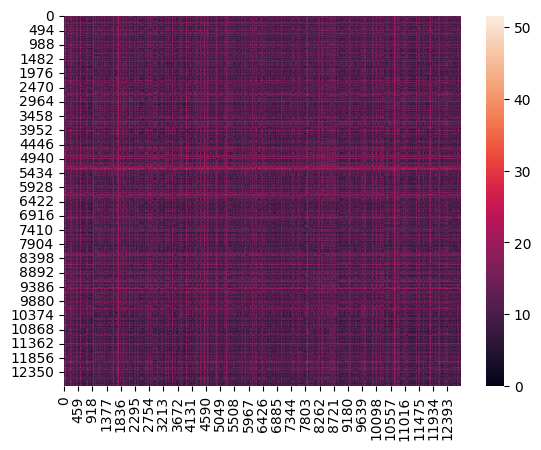

In [59]:
sns.heatmap(mt)

In [ ]:
# hac
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
clusters = shc.linkage(mt, 
            method='ward', 
            metric="euclidean")
#pd.DataFrame(clusters).to_csv('hac_clusters.csv',index=False)

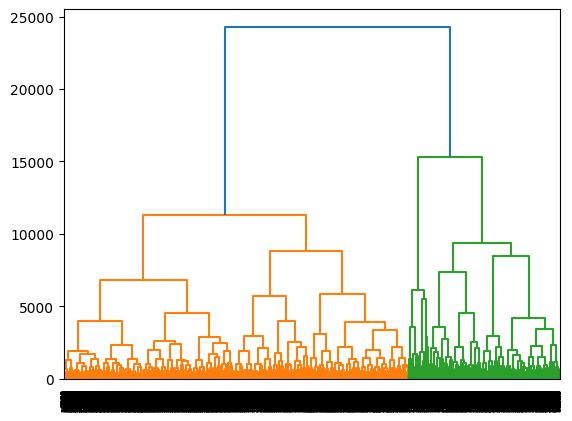

In [61]:
shc.dendrogram(Z=clusters)
plt.show()